# Bayesian Regression (JAGS)

## Introduction

This analysis focused on the predictors of house prices in the USA.

The data was taken from Anglin and Gencay (1996) and contains 546 observations.

In [1]:
set.seed(42)

In [2]:
# loads packages

library(data.table)
library(ggplot2)
library(rjags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs



In [3]:
# sets theme for ggplot2

theme_set(theme_bw() + theme(panel.border=element_blank(), panel.grid.major=element_blank(), panel.grid.minor=element_blank(), axis.line=element_line(colour="black")))

In [4]:
# loads data set

dat_house<-fread("Data/Data_House_Prices.csv")

## Data Visualisation

In [5]:
plt_hist_sell<-ggplot(dat_house) +
  aes(x=sell) + 
  geom_histogram(aes(y=..density..), binwidth=5000, col="black") +
  scale_y_continuous(expand=c(0, 0)) +
  ggtitle("Figure 1. Histogram of House Prices.") +
  labs(y="Density", x="sell")

As shown below in Figure 1, house prices are positively skewed and were therefore log transformed.

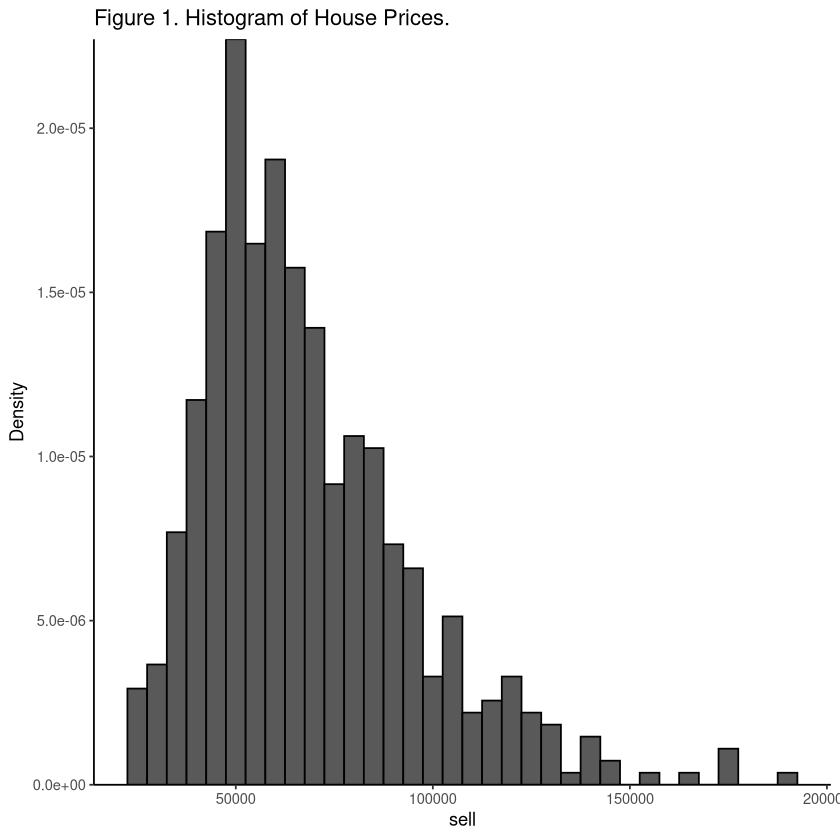

In [6]:
plt_hist_sell

In [7]:
plt_hist_log_sell<-ggplot(dat_house) +
  aes(x=log(sell)) + 
  geom_histogram(aes(y=..density..), binwidth=.1, col="black") +
  scale_y_continuous(expand=c(0,0)) +
  ggtitle("Figure 2. Histogram of log(House Prices)") +
  labs(y="Density", x="Log(sell)")

The log of house prices more closely resembles a normal distribution, as shown in Figure 2.

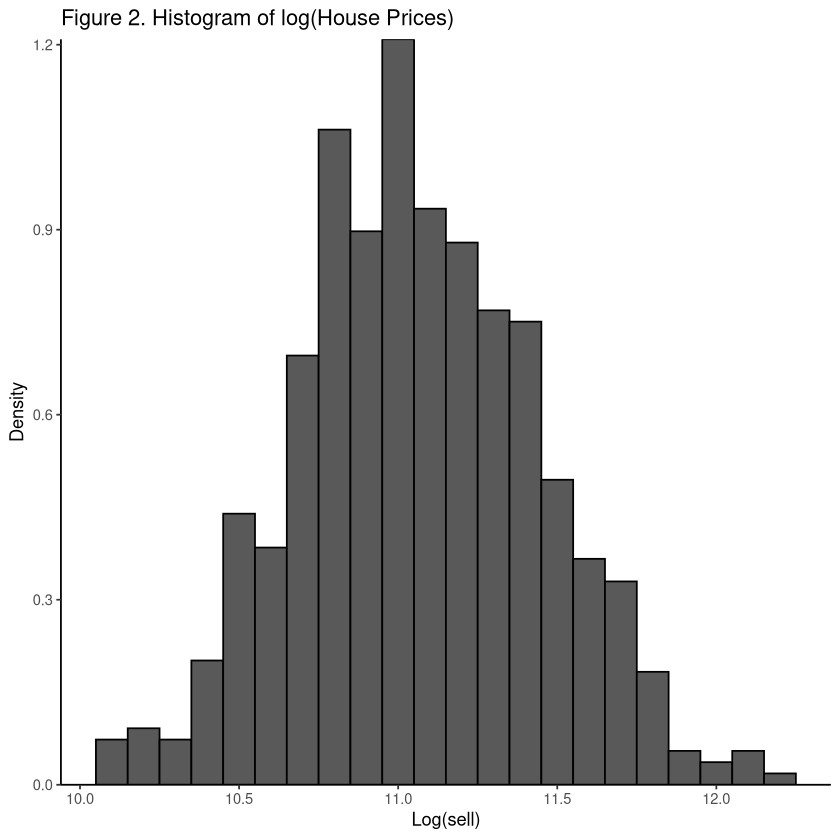

In [8]:
plt_hist_log_sell

## Model

The model of interest is:

$$
\log(\mathit{sell})_i = \beta_1 + \beta_2 \mathit{lot}_i + \beta_3 \mathit{bdms}_i + \beta_4 \mathit{fb}_i + \beta_5 \mathit{drv}_i + \beta_6 \mathit{ca}_i + \beta_7 \mathit{reg}_i + \varepsilon_i, \varepsilon_i \sim N(0, \sigma^2)
$$

where $\mathit{sell}$ is the sale price of a house, $\mathit{lot}$ is the lot size (in $\mathit{ft}^2$), $\mathit{bdms}$ is the number of bedrooms, $\mathit{fb}$ is the number of bathrooms, $\mathit{drv}$ is whether the house had a driveway (1 vs 0), $\mathit{ca}$ is whether the house had central air conditioning (1 vs 0), and $\mathit{reg}$ is whether the house was located in a preferred neighbourhood (1 vs 0).

Non-informative priors were used for $\beta$:

$$
\beta_k \sim N(0, 1000000),k = 1, ..., 7
$$

As for $\sigma^2$, the following prior was used:

$$
\sigma^2 \sim \text{IG}(\frac{200}{2}, \frac{200 \times 0.5}{2})
$$

Here the effective sample size is set to 200, while the prior guess of the variance is set to 0.5.

In [9]:
string_m_jags_house<- " model {

  for (i in 1:length(log_sell)) {

        log_sell[i]~dnorm(mu[i], prec)

        mu[i]<-b[1] + b[2] * lot[i] + b[3] * bdms[i] + b[4] * fb[i] + b[5] * drv[i] + b[6] * ca[i] + b[7] * reg[i] 

    }
    
    for (j in 1:7) {

        b[j]~dnorm(0, 1/1e6)

    }
    
    prec~dgamma(200/2, 200*.5/2) # here the model estimates precision, which needs to be inversed to obtain variance
    
    sig2<-1/prec

    sig<-sqrt(sig2)
    
} "

In [10]:
dat_house[, log_sell:=log(sell)]

list_dat_house<-as.list(dat_house[, .(log_sell, lot, bdms, fb, drv, ca, reg)])

m_jags_house<-jags.model(textConnection(string_m_jags_house), data=list_dat_house, n.chains=3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 546
   Unobserved stochastic nodes: 8
   Total graph size: 4614

Initializing model



### First Run

A burn-in of 1000 iterations were run, then three chains were run for 5000 iterations.

In [11]:
update(m_jags_house, 1000)

# the chains took a while to run, so I saved the output as an object and commented out the commands

# sim_jags_house_5000<-coda.samples(model=m_jags_house, variable.names=c("b", "sig"), n.iter=5000)

# save(sim_jags_house_5000, file="Data/Objects_Bayesian_Chains_House_Prices_5000.RData")

load("Data/Objects_Bayesian_Chains_House_Prices_5000.RData")

Traceplots of the parameters are shown below and there was no obvious long-term trend.

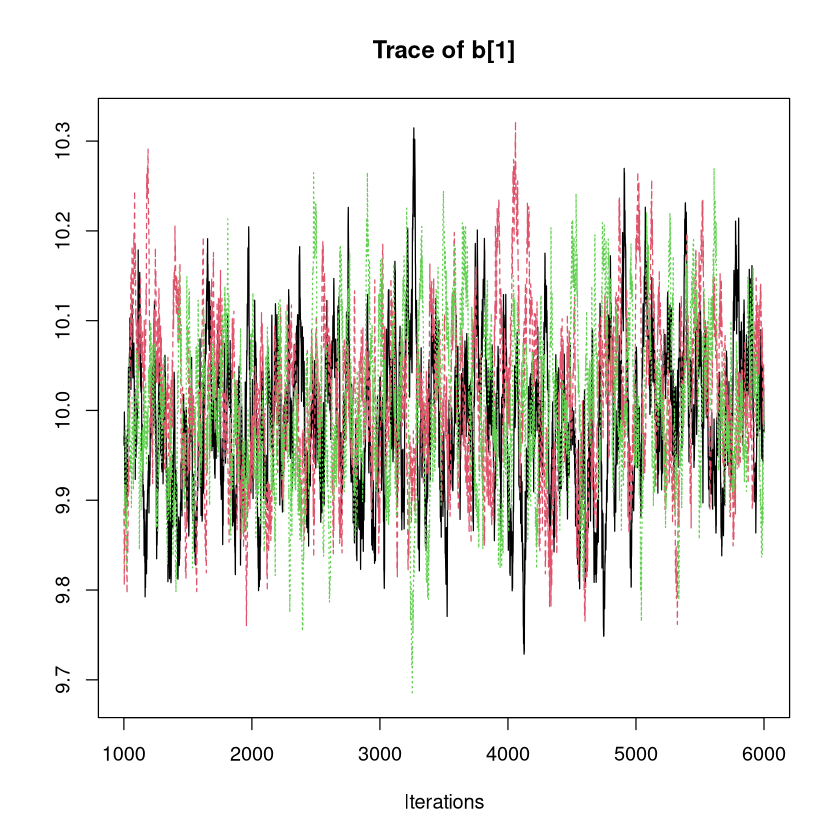

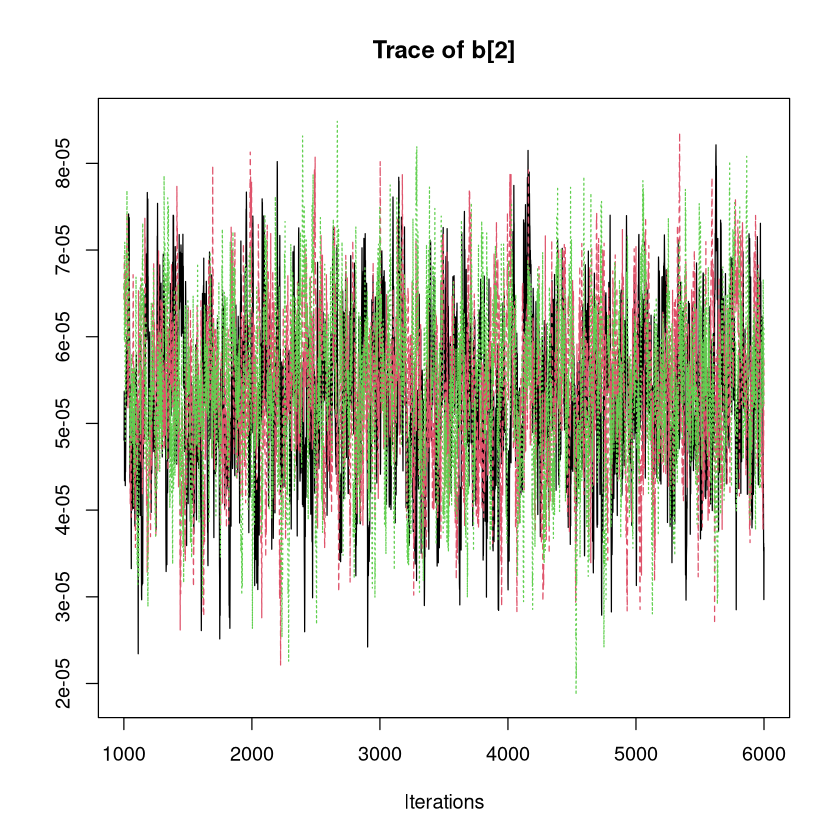

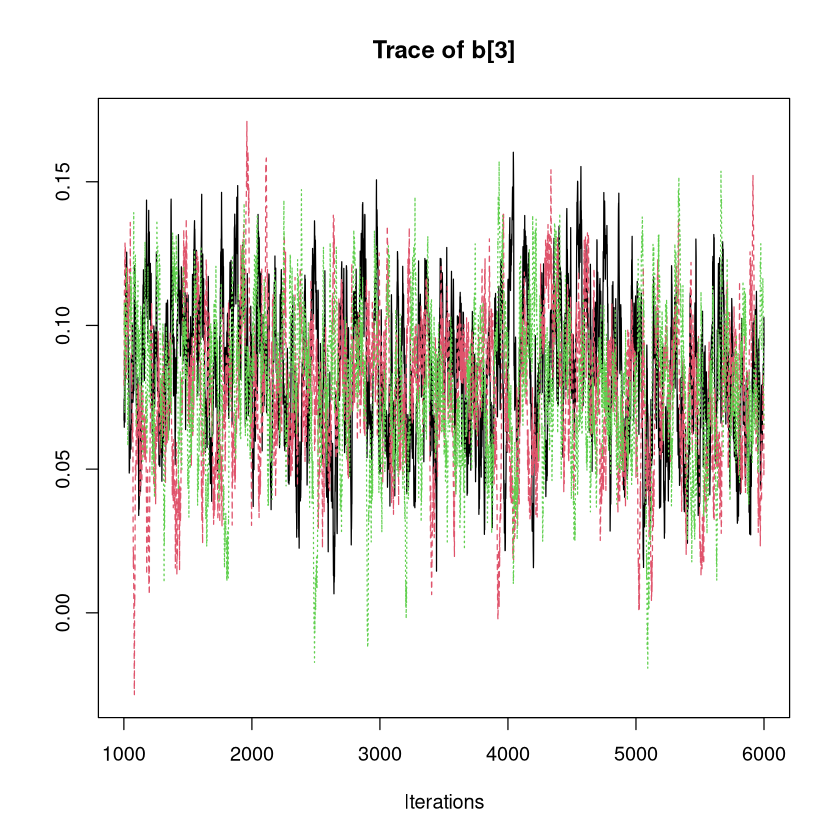

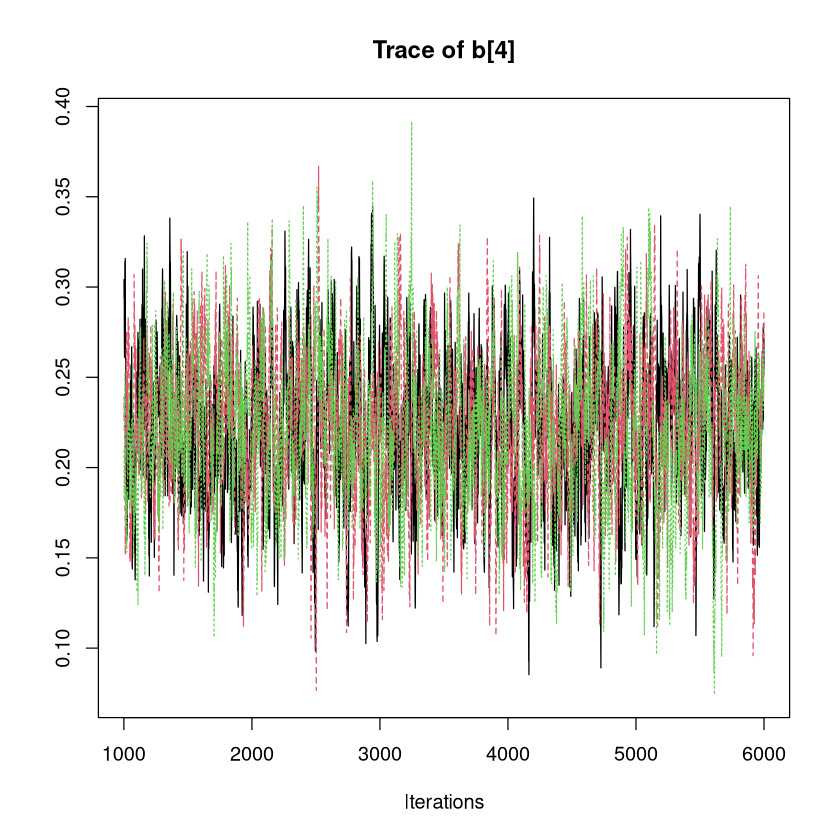

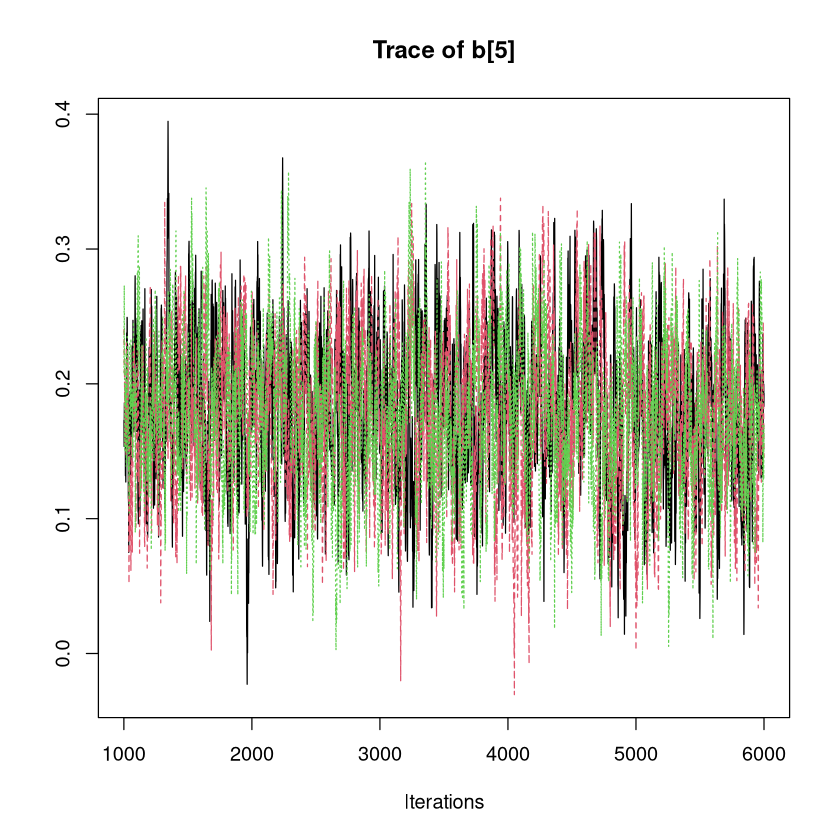

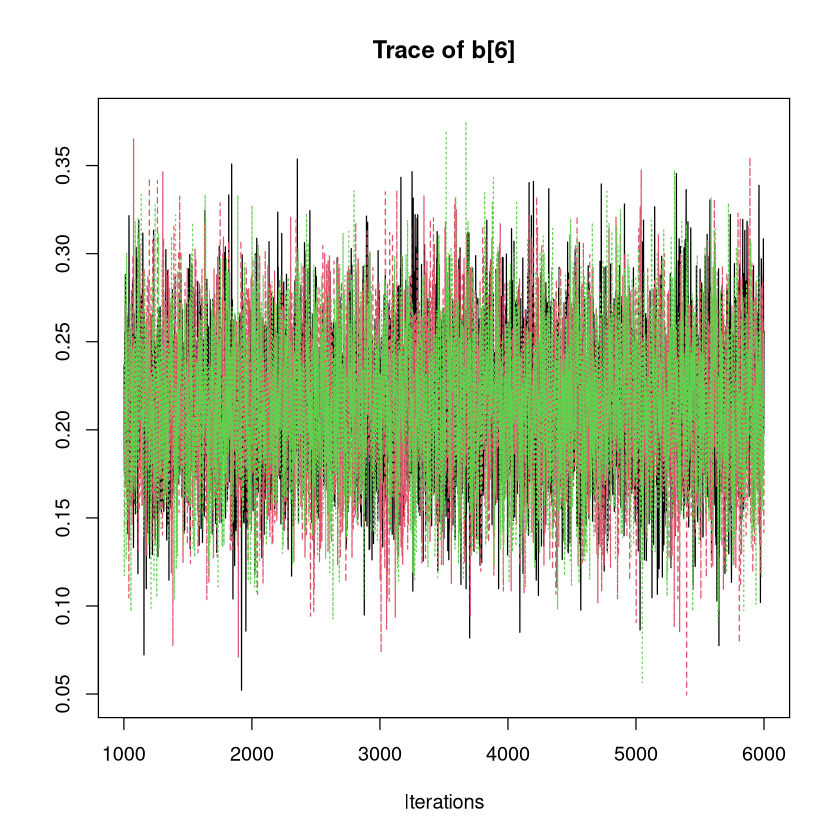

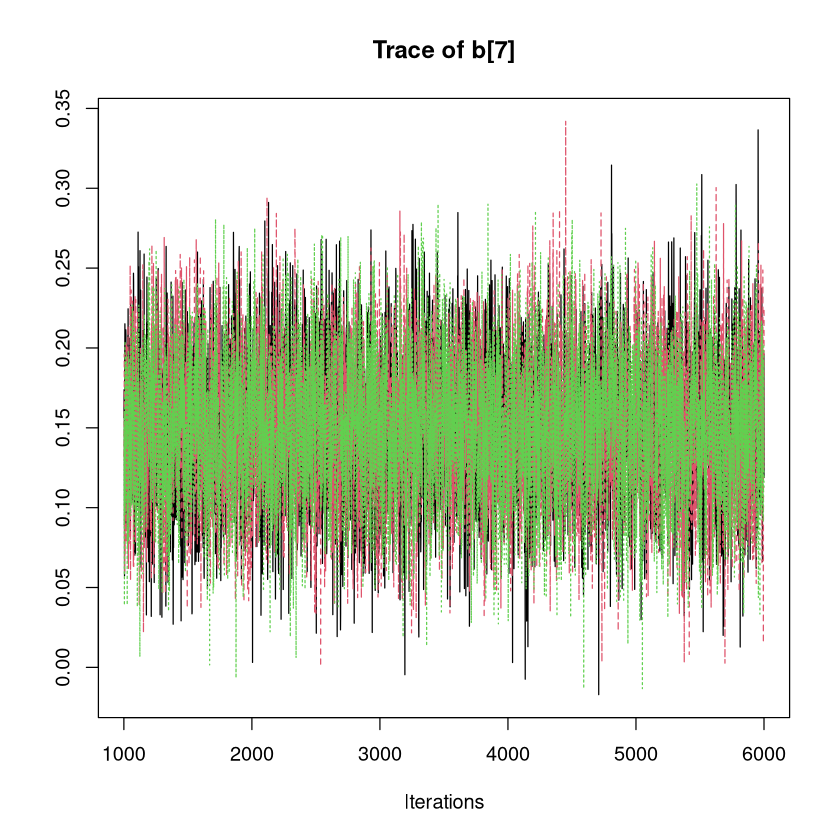

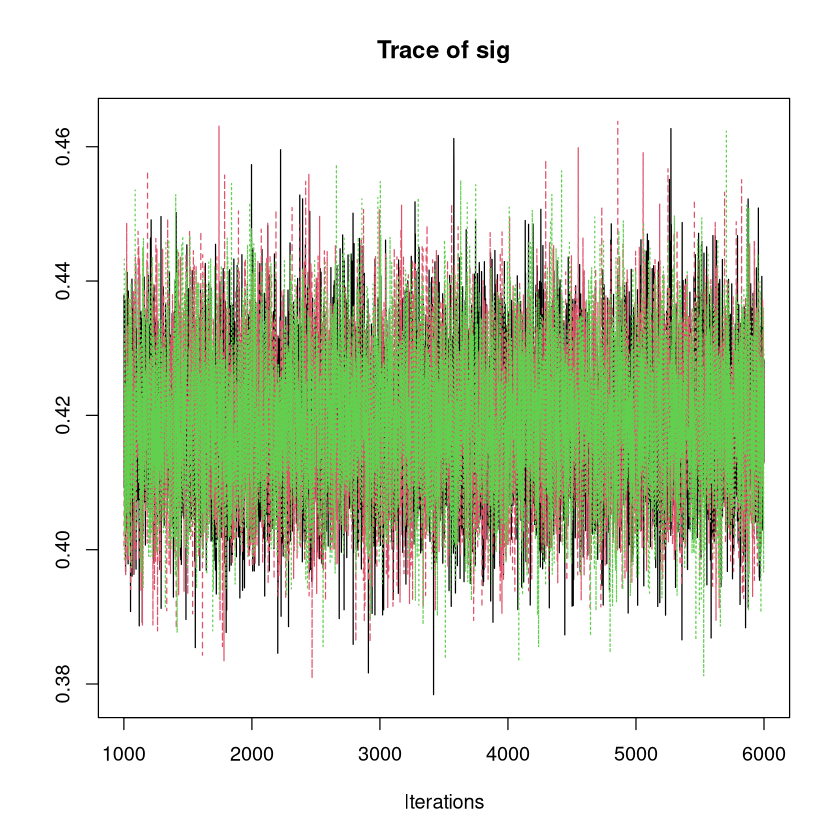

In [12]:
traceplot(sim_jags_house_5000)

Autocorrelations were high for lags 1 and 5 of some parameters, although the values dropped remarkably after lag 10.

In [13]:
autocorr.diag(sim_jags_house_5000)

b[1]       b[2]       b[3]         b[4]        b[5]       b[6]        
Lag 0  1.00000000  1.0000000  1.000000000  1.00000000 1.00000000  1.000000000
Lag 1  0.95780054  0.8717318  0.947496312  0.89292330 0.87435753  0.369833099
Lag 5  0.81435064  0.5187698  0.758030121  0.56022809 0.51908502  0.034962328
Lag 10 0.65454700  0.2681128  0.563293105  0.27786947 0.27585123  0.001309983
Lag 50 0.03381069 -0.0334313 -0.005103618 -0.05136745 0.01744665 -0.003121267
       b[7]        sig         
Lag 0  1.000000000  1.000000000
Lag 1  0.282859773  0.005394405
Lag 5  0.014189781  0.006461757
Lag 10 0.016670966 -0.011766452
Lag 50 0.008453539  0.003428381

Effective sample sizes were very low for most parameters, however the Gelman and Rubin diagnostic showed that the scale reduction factors were acceptable.

In [14]:
effectiveSize(sim_jags_house_5000)

gelman.diag(sim_jags_house_5000)

b[1]       b[2]       b[3]       b[4]       b[5]       b[6]       b[7] 
  302.8671  1084.1366   411.2714   837.7363  1005.3131  6403.1169  7759.6633 
       sig 
14800.3155

Potential scale reduction factors:

     Point est. Upper C.I.
b[1]       1.01       1.04
b[2]       1.00       1.01
b[3]       1.01       1.03
b[4]       1.00       1.01
b[5]       1.00       1.01
b[6]       1.00       1.00
b[7]       1.00       1.00
sig        1.00       1.00

Multivariate psrf

1.01

Finally, the Raftery and Lewis diagnostic showed that a much higher number of iterations was needed for reliable credible intervals.

In [15]:
raftery.diag(sim_jags_house_5000)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                            
      Burn-in  Total Lower bound  Dependence
      (M)      (N)   (Nmin)       factor (I)
 b[1] 24       22926 3746         6.12      
 b[2] 16       16642 3746         4.44      
 b[3] 18       21819 3746         5.82      
 b[4] 24       26232 3746         7.00      
 b[5] 14       13788 3746         3.68      
 b[6] 4        4955  3746         1.32      
 b[7] 3        4484  3746         1.20      
 sig  2        3803  3746         1.02      


[[2]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                            
      Burn-in  Total Lower bound  Dependence
      (M)      (N)   (Nmin)       factor (I)
 b[1] 39       45939 3746         12.300    
 b[2] 20       21082 3746          5.630    
 b[3] 54       53370 3746         14.200    
 b[4] 18       17784 3746          4.750    
 b[5] 16       15606 3746         

### Second Run

The three chains were re-run for 75000 iterations.

In [16]:
# the chains took a while to run, so I saved the output as an object and commented out the commands

# sim_jags_house_75000<-coda.samples(model=m_jags_house, variable.names=c("b", "sig"), n.iter=75000)

# save(sim_jags_house_75000, file="Data/Objects_Bayesian_Chains_House_Prices_75000.RData")

load("Data/Objects_Bayesian_Chains_House_Prices_75000.RData")

## Results

In [17]:
summary(sim_jags_house_75000)


Iterations = 6001:81000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 75000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean        SD  Naive SE Time-series SE
b[1] 1.001e+01 9.132e-02 1.925e-04      1.166e-03
b[2] 5.383e-05 9.111e-06 1.921e-08      6.426e-08
b[3] 7.895e-02 2.662e-02 5.613e-05      3.375e-04
b[4] 2.209e-01 3.900e-02 8.222e-05      3.215e-04
b[5] 1.774e-01 5.452e-02 1.149e-04      4.398e-04
b[6] 2.147e-01 4.036e-02 8.508e-05      1.382e-04
b[7] 1.493e-01 4.418e-02 9.315e-05      1.348e-04
sig  4.191e-01 1.093e-02 2.305e-05      2.342e-05

2. Quantiles for each variable:

          2.5%       25%       50%       75%     97.5%
b[1] 9.829e+00 9.947e+00 1.001e+01 1.007e+01 1.019e+01
b[2] 3.597e-05 4.773e-05 5.383e-05 5.993e-05 7.179e-05
b[3] 2.629e-02 6.117e-02 7.905e-02 9.669e-02 1.313e-01
b[4] 1.440e-01 1.948e-01 2.210e-01 2.472e-01 2.973e-01
b[5] 6.979e-02 1.408e-01 1.775e-01 2.141e-

### Point Estimates

The posterior means of the parameters are as follows.

In [18]:
posterior_means<-summary(sim_jags_house_75000)$statistics[,1]

In [19]:
posterior_means

b[1]         b[2]         b[3]         b[4]         b[5]         b[6] 
1.000817e+01 5.383436e-05 7.895270e-02 2.209068e-01 1.773942e-01 2.146794e-01 
        b[7]          sig 
1.493389e-01 4.191271e-01

In [20]:
dat_house[, log_sell_hat:=(posterior_means[1]+posterior_means[2]*lot+posterior_means[3]*bdms+posterior_means[4]*fb+posterior_means[5]*drv+posterior_means[6]*ca+posterior_means[7]*reg)]

dat_house[, residuals:=log_sell-log_sell_hat]

Since the model is a linear regression, the residuals were checked directly with the Shapiro-Wilk normality test.

Results show that the residuals were normally distributed, $p = .06$, although it was borderline significant.

In [21]:
shapiro.test(dat_house$residuals)


	Shapiro-Wilk normality test

data:  dat_house$residuals
W = 0.9947, p-value = 0.05642


### Posterior Distrbutions of Parameters

The posteriors of the parameters are as follows:

In [22]:
combined_chains_house<-as.mcmc(do.call(rbind, sim_jags_house_75000))

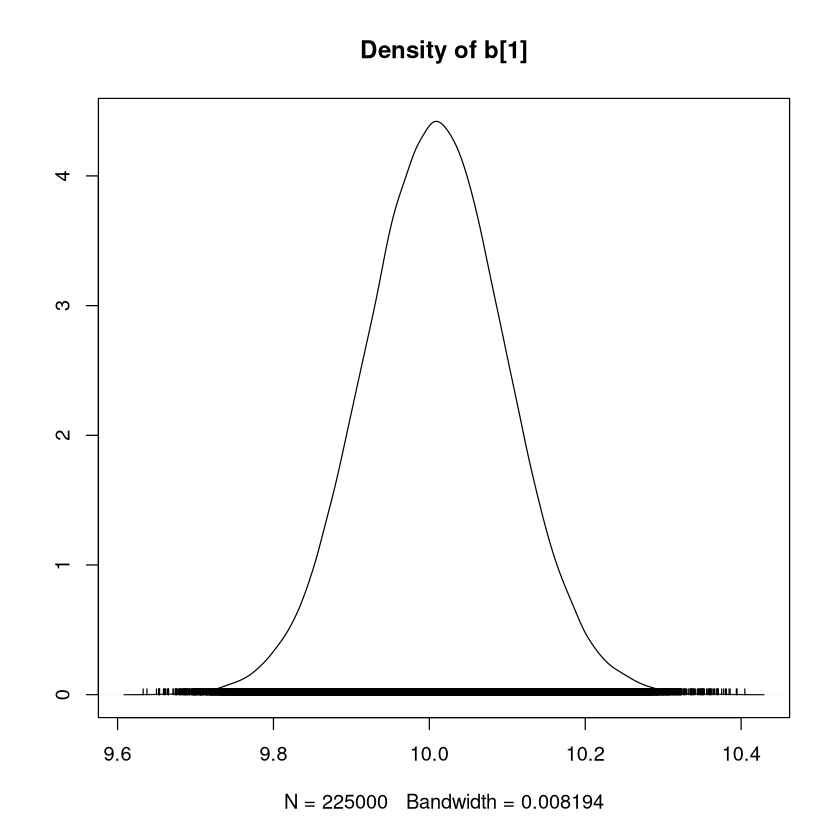

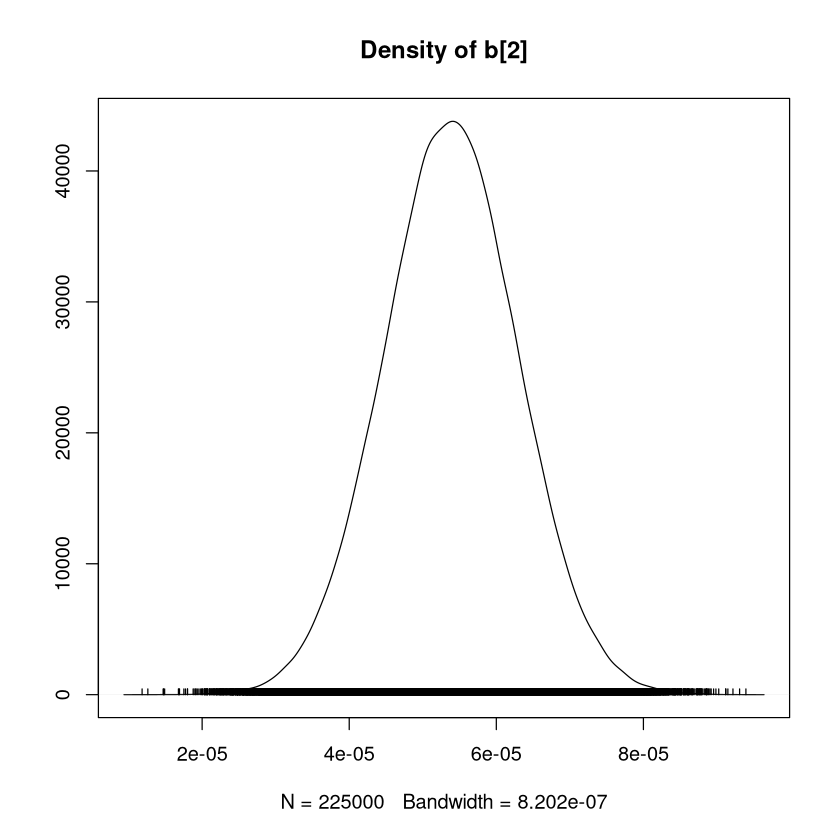

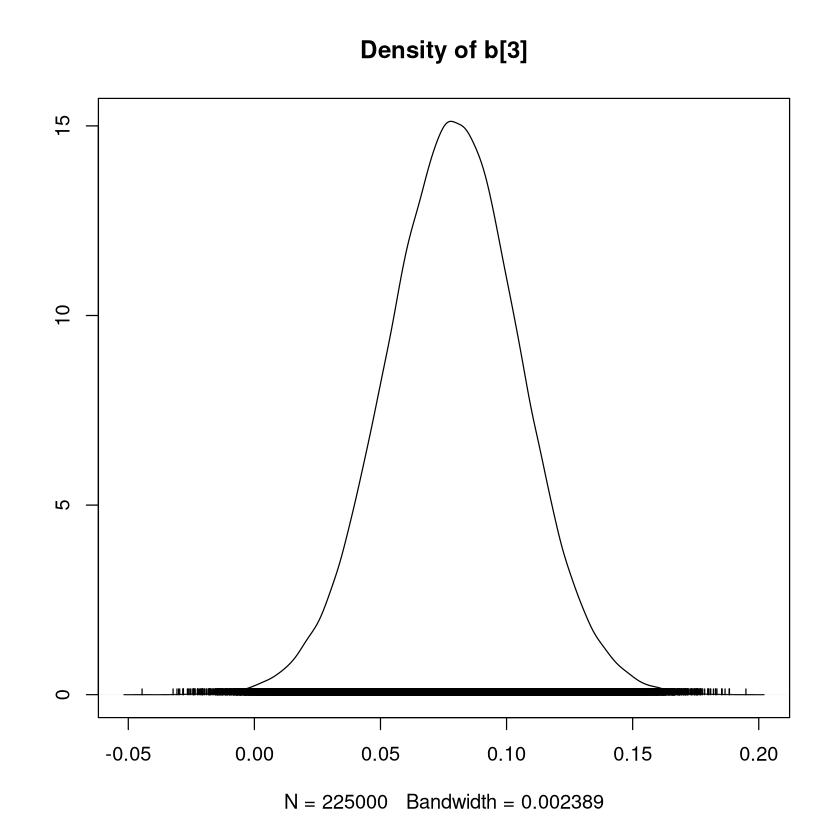

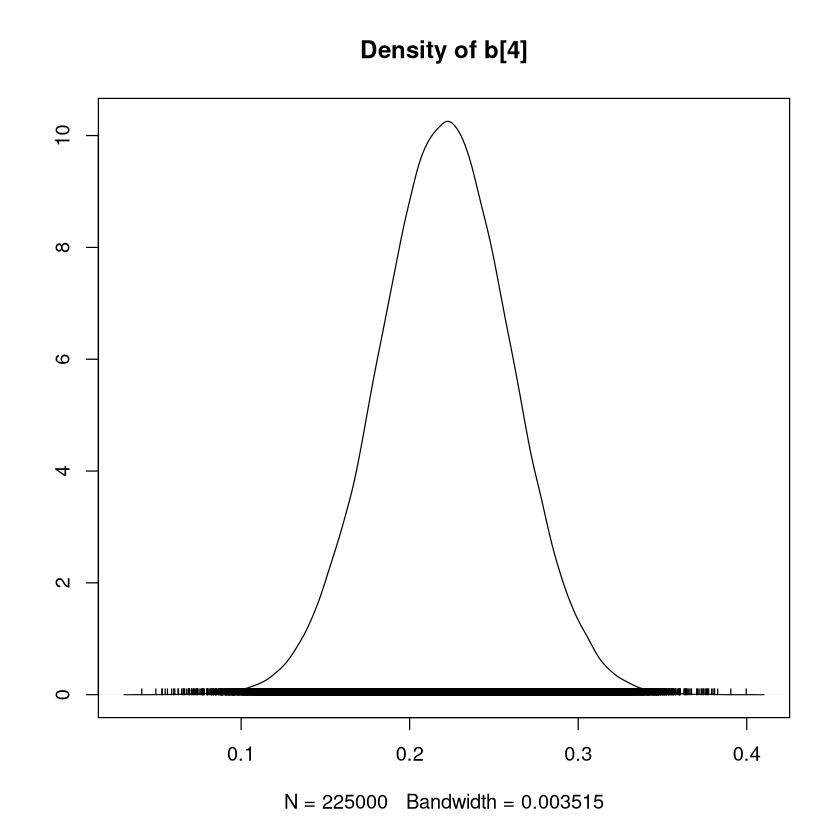

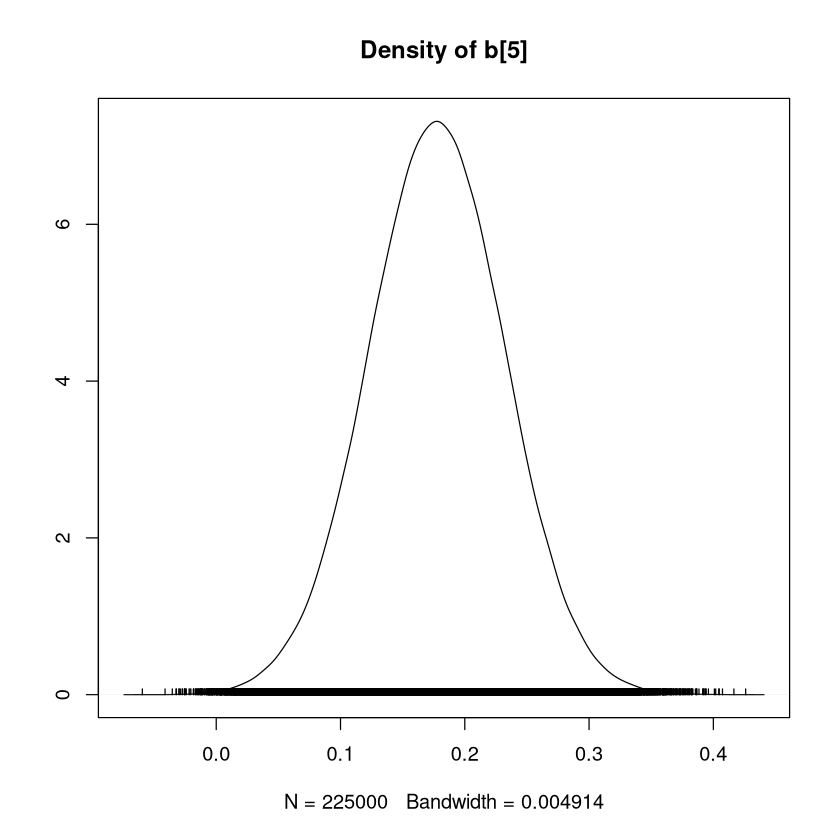

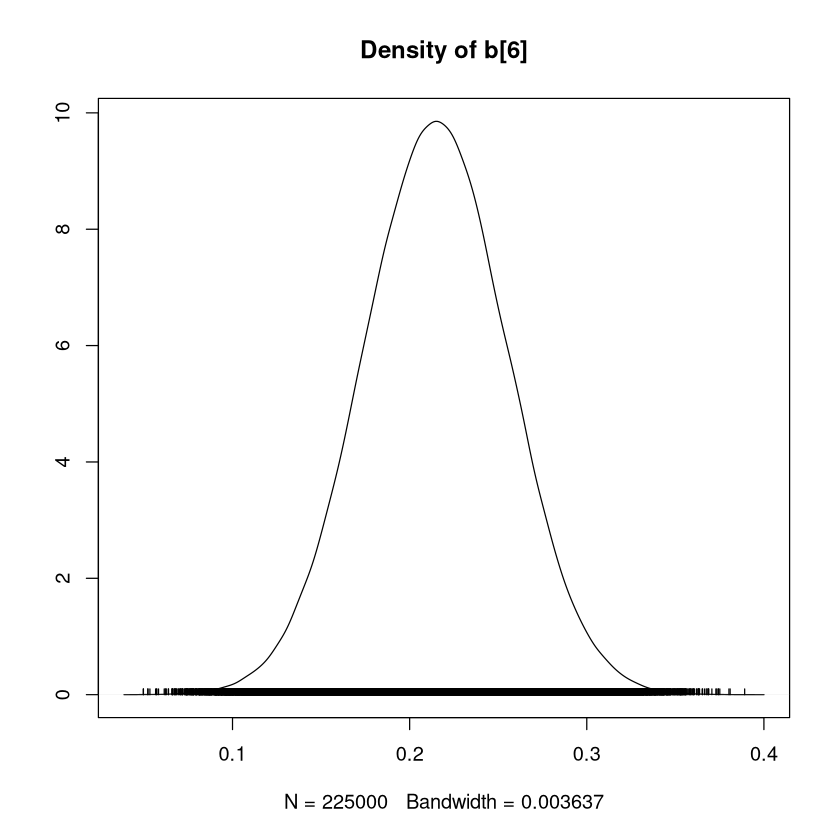

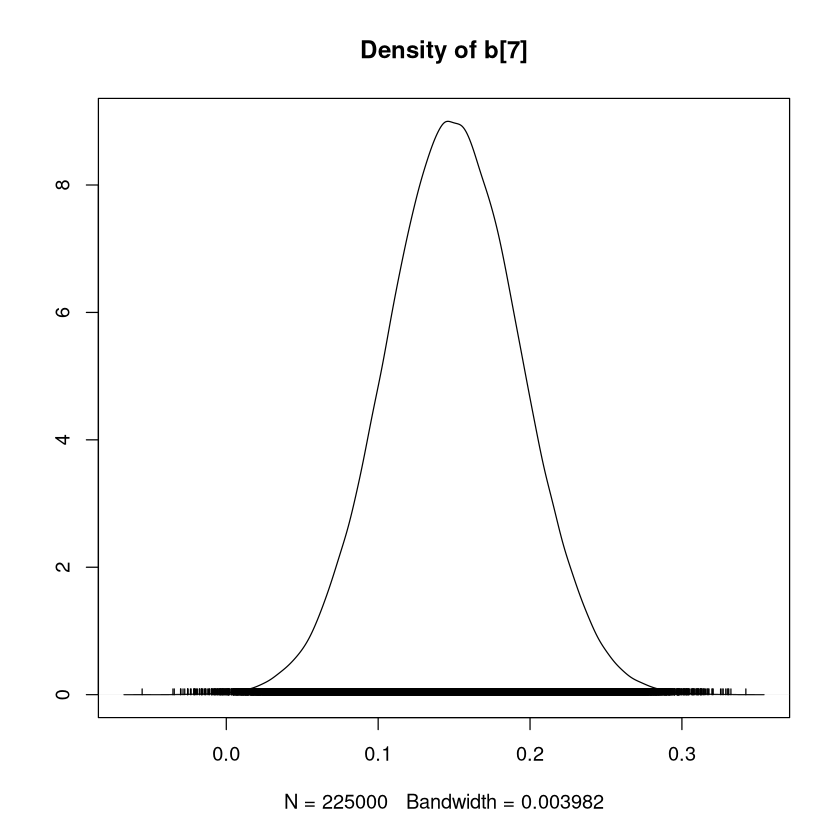

In [23]:
densplot(combined_chains_house[, 1:7])

### 95% Credible Intervals

As shown below, none of the intervals overlapped with 0.

In [24]:
dt_combined_chains_house<-as.data.table(combined_chains_house)

CI_lower<-lapply(dt_combined_chains_house[, 1:7], function(x) quantile(x, .025))
CI_upper<-lapply(dt_combined_chains_house[, 1:7], function(x) quantile(x, .975))
                 
as.data.frame(cbind(CI_lower, CI_upper))

CI_lower    CI_upper    
b[1] 9.829039    10.18831    
b[2] 3.59748e-05 7.179017e-05
b[3] 0.02629484  0.1313239   
b[4] 0.1440095   0.2973284   
b[5] 0.06978526  0.2843231   
b[6] 0.1357078   0.2937707   
b[7] 0.06287398  0.2361

## Reference Model

A frequentist model was created as reference.

Consisent with the 95% credible intervals, all parameters were significant.

In [25]:
lm_reference<-lm(log(sell)~lot+bdms+fb+drv+ca+reg, data=dat_house)

summary(lm_reference)


Call:
lm(formula = log(sell) ~ lot + bdms + fb + drv + ca + reg, data = dat_house)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74456 -0.13741  0.00159  0.14707  0.86003 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.001e+01  5.110e-02 195.853  < 2e-16 ***
lot         5.383e-05  5.086e-06  10.585  < 2e-16 ***
bdms        7.889e-02  1.482e-02   5.322 1.51e-07 ***
fb          2.206e-01  2.192e-02  10.064  < 2e-16 ***
drv         1.779e-01  3.048e-02   5.836 9.21e-09 ***
ca          2.147e-01  2.249e-02   9.547  < 2e-16 ***
reg         1.493e-01  2.466e-02   6.056 2.62e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2342 on 539 degrees of freedom
Multiple R-squared:  0.6079,	Adjusted R-squared:  0.6035 
F-statistic: 139.3 on 6 and 539 DF,  p-value: < 2.2e-16
